In [1]:
import os
import sys

path = os.getcwd()
while os.path.basename(os.path.normpath(path)) != 'roman-pandeia':
    path = os.path.dirname(path)
repo_path = path
if repo_path not in sys.path:
    sys.path.append(repo_path)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from glob import glob
import multiprocessing
import pandas as pd
from tqdm import tqdm
import time
from copy import deepcopy
from multiprocessing import Pool

from package.helpers.test_physical_lens import TestPhysicalLens
from package.helpers.lens import Lens
from package.plots import diagnostic_plot, plot
from package.utils import util
from package.scripts import generate

plt.style.use(f'{repo_path}/package/mplstyle/science.mplstyle')

In [3]:
data_dir = os.path.join('/data','bwedig', 'roman-pandeia')
array_dir = os.path.join(data_dir, 'output', 'arrays', 'multiprocessing')
util.create_directory_if_not_exists(array_dir)

# get path to Roman instrument params CSV
roman_params_csv = os.path.join(repo_path, 'data', 'roman_spacecraft_and_instrument_parameters.csv')

# get output of SkyPy pipeline
df = pd.read_csv(os.path.join('/data','bwedig', 'roman-population', 'data', 'dictparaggln_Area00000010.csv'))

In [4]:
limit = 100
total = deepcopy(limit)
lens_list = []

In [5]:
# generate the lens objects
for i, row in tqdm(df.iterrows(), total=total):
    if i == limit:
        break

    # select only the cool ones lmao
    # if row['numbimag'] == 1.0:
    #     limit += 1
    #     continue

    lens = Lens(z_lens = row['redslens'], 
                z_source=row['redssour'], 
                sigma_v=row['velodisp'], 
                lens_x=row['xposlens'], 
                lens_y=row['yposlens'], 
                source_x=row['xpossour'], 
                source_y=row['ypossour'], 
                mag_lens=row['magtlensF106'], 
                mag_source=row['magtsourF106'])
    
    lens_list.append(lens)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:01<00:00, 82.80it/s]


In [6]:
pool = Pool(processes=multiprocessing.cpu_count()) 
output = []

for each in tqdm(pool.map(generate.main, lens_list), total=len(lens_list)):
    output.append(each)

100%|██████████| 100/100 [00:00<00:00, 747647.77it/s]


In [7]:
image_list, execution_times, num_point_sources = [], [], []

for tuple in output:
    (image, execution_time, num_ps) = tuple
    image_list.append(image)
    execution_times.append(execution_time)
    num_point_sources.append(num_ps)

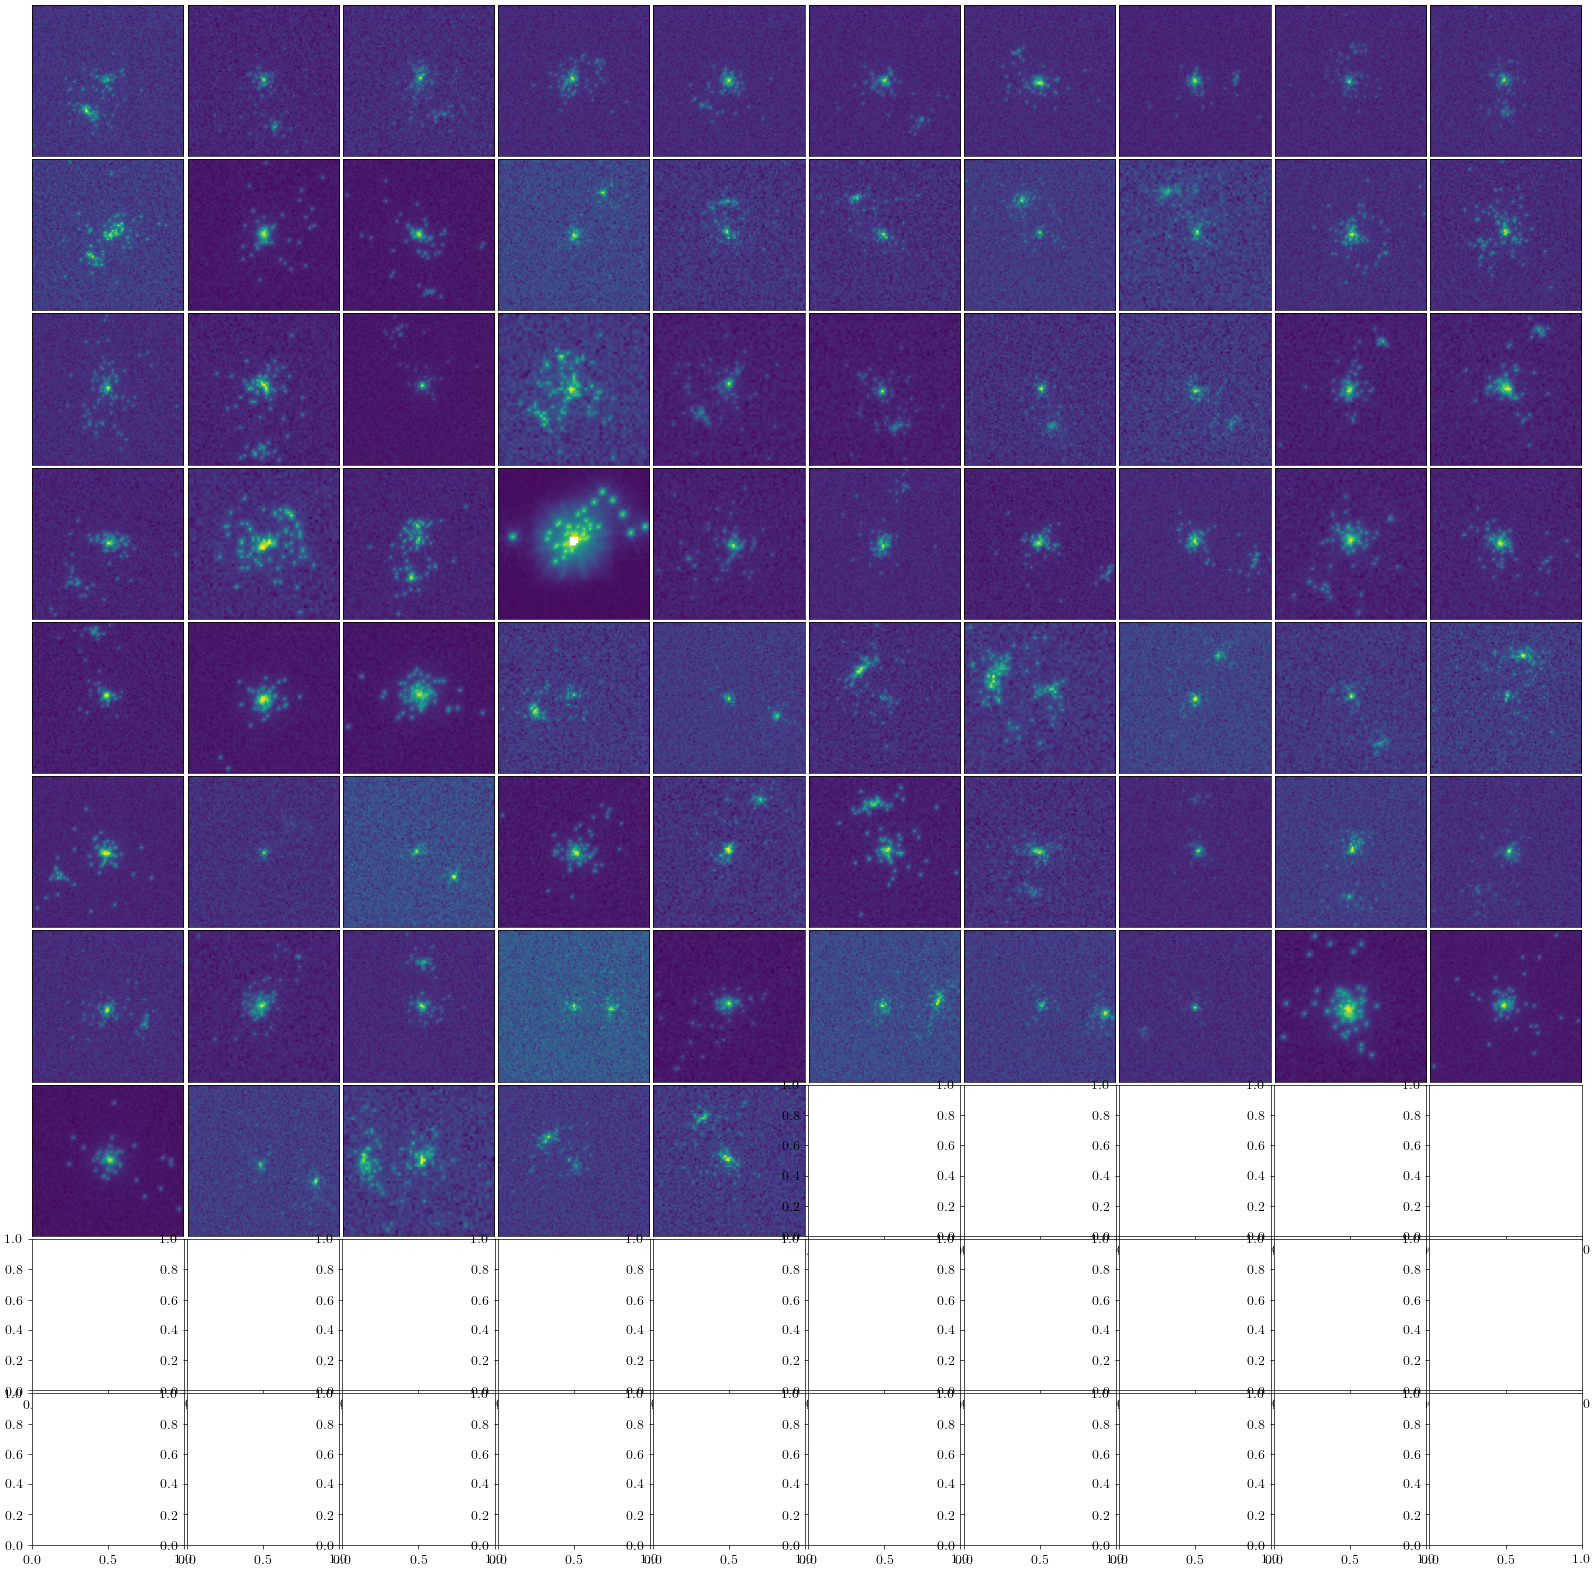

In [8]:
image_list = [i for i in image_list if i is not None]

plot.plot_grid(image_list, side=10)

In [9]:
for image in image_list:
    np.save(os.path.join(array_dir, f'skypy_output_{str(i).zfill(5)}'), image)

In [10]:
# save lists of execution times
np.save(os.path.join(array_dir, 'skypy_output_execution_times.npy'), execution_times)
np.save(os.path.join(array_dir, 'skypy_output_num_point_sources.npy'), num_point_sources)